# Navigation

---

In this notebook, you will see the [DQN algorithm](https://en.wikipedia.org/wiki/Q-learning) in action learning to collect yellow bananas inside a Unity ML-Agents environment.

This was part of the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) done in October 2018. 

## 1. Collecting Bananas?

Yep! I'm originally from Colombia and we like Bananas so much that this tasks sounds pretty (yummy) interesting. Going back to the serious stuff, this environment is a small step towards the holly-grail autonomous navigation. The agent needs to learn to move by itself inside an environment reinforce by the fact that he is eating delicious bananas.

<img src="https://user-images.githubusercontent.com/10624937/42135619-d90f2f28-7d12-11e8-8823-82b970a54d7e.gif" /> 

In the previous video, we could watch an informative and straightforward environment to assess free navigation of agents. The challenge consists in autonomously devise a plan to collect as many yellow bananas (healthy) while avoid collecting the blue bananas (rotten). Note that the bananas are randomly placed such that the agent does not learn to memorize locations.

Before moving forward let's double check that you have all the necessary packages. If the code cell below returns an error, please revisit the instructions in the README to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md), [NumPy](http://www.numpy.org/) and [Pytorch](https://pytorch.org/).

In [1]:
import os
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import torch
from unityagents import UnityEnvironment

from dqn_agent import Agent
%matplotlib notebook

## 1.a Environment setup

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

In [2]:
file_name = "Banana.app"
env = UnityEnvironment(file_name=file_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Unity environments contain *brains* which are responsible for deciding the actions of their associated agents.

As the simulation contains a single agent that navigates a large environment. In this case, at each time step our a has four actions at its disposal:

- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana (healthy), and a reward of `-1` is provided for collecting a blue banana (rotten). 

## 2. Learning with DQN

Based on the previous details of the environment, we are ready to discuss how to (automatically) devise a strategy to collect as many yellows bananas as possible. In this case, we will use the Q-learning algorithm.

Q-learning is a generic algorithm that distills a particular strategy for solving a problem without explicitly coding up the actions of the agent at every step. How does it do that?

### 2.1 The setup

As you will find out, it does that in a very simple way. Q-learning relies on the fact that we can freely interact and receive rewards with/from the environment which is precisely the case outlined in the previous section. Every moment in time, our agent collects information about the environment, i.e. itself and the things in front of it (the so-called state space of `37` dimensions); and it takes action (from 0-4 which form the so-called action space). Subsequently, it will recive another packet of information, i.e. a new `37` dimensional vector; and the reward (`+1/-1` for collecting a yellow/blue banana or `0` othersiwe, i.e. nothing was collected). This process will repeat for a period of time, and our agent will be able to assess how many bananas it collects following a particular strategy.

Pythonically speaking we could summarize this process in the following way:

```python
def interaction(agent, env, eps=1):
    "Return the experience of a single interaction"
    brain_name = env.brain_names[0]
    state = env[brain_name].vector_observations[0]
    
    action = agent.act(state, eps)
    
    env_info = env.step(action)[brain_name]
    next_state = env[brain_name].vector_observations[0]
    reward = env[brain_name].rewards[0]
    done = env[brain_name].local_done[0]
    return state, action, next_state, reward, done
```

This function grants our agent with access to an environment where it can safely play and collect a reward. To unroll multiple instances of this, we only place the previous function inside a `while` loop which runs over a finite horizon determined by the environment (`done == True`).

```python
score = 0
while True:
    # Interaction
    state, action, next_state, reward, done = interaction(
        agent, env)
    score += reward

    # Collecting or Learning
    agent.step(state, action, reward, next_state, done)
    if done:
        break
```

Note that after we interact with the environment, our agent will proceed to "collect or learn" from this experience. We will discuss this step in more details in what follows.

### 2.1 Q-learning core

In layman terms, we can think about Q-learning as an update rule of a guess with another guess.

Let's add a bit of notation to not get loss with hand wavy explanations. Let's pretend  that our agents somehow is able to map a given environment state $s \in \mathbb{R}^{37}$ into an action $a \in \{0,1,2,3\}$. More contretely, let's assume that our agent is capable to determine the value of each of its actions $A$ for a given state $s \in S$ which we would denote as $Q(s, a; w)$.

> $w$ represents the internal parameters of our agent and the denotation $Q(\dots;w)$ only strengh the fact that our function $Q$ is tied to $w$.

The Q-learning algorithm proposes to update the $Q(\dots;w)$ function of our agent by only focusing on the current <b>S</b>tate $s$, <b>A</b>ction $a$, subsequent <b>R</b>eward $r$, the next <b>S</b>tate $s'$, the most advantageous next <b>A</b>ction as follows:

$\Delta w = \alpha \color{red}{(} r + \gamma max_a Q(s',a; w) - Q(s, a; w)\color{red}{)} \nabla_{w} Q(s, a; w)$

where $\alpha$ is the so-called learning rate which determines how fast we update; and $\gamma$ is a discount factor to give more or less priority to the inmediate reward.

For simplicity, let's disregard the gradient operation $\nabla_{w} Q(s, a; w)$ and the factor $\alpha$ as they only accounts for the fact that the $Q(\dots;w)$ function of our agent is differentiable and the rate of update of the parameters $w$.

The term inside the $\color{red}{\text{red}}$ parentheses represents the error of our agent on the estimation of the expected action-state value function $Q(s, a; w)$ which is usually called [_TD-Error_](https://en.wikipedia.org/wiki/Temporal_difference_learning). In a nutshell, all what the update is telling us is to change $w$ such that the $Q(s, a;w)$ function of our agents predicts values closer to the expected return i.e. the reward $r$ and the optimal future reward $\gamma max_a Q(s',a; w)$ in the next state $s'$.

It would be overly optimistic to assume that our agent will learn to navigate from a single episode or trial with the environment. Thus, it's fair to repeat the same procedure multiple times or `episodes` as follow:

```python
scores = []
for i_episode in range(1, n_episodes + 1):
    env_info = env.reset(train_mode=True)[env.brain_names[0]]
    score = 0
    while True:
        # Interaction
        state, action, next_state, reward, done = interaction(
            agent, env, eps)
        score += reward

         # Learn - Collect
        agent.step(state, action, reward, next_state, done)

        if done:
            break                
    
    scores.append(score)

    # epsilon greedy policy
    eps = max(eps_end, eps_decay * eps)
```

The last line inside the `for` loop only means that we make use of an [epsilon greedy policy](https://jamesmccaffrey.wordpress.com/2017/11/30/the-epsilon-greedy-algorithm/) to determine the action of our agent. Roughly speaking, it allows that our agent takes random actions from time to time instead of blindly focusing on its $Q(s, a;w)$. Think about the first round of episodes where our agent strategy may not be optimal, just trusting that would yield into a sub-optimal strategy. In this particular case, we are using an exponential decay of the epsilon values as the episodes progress. Notice as well that we clamp its value such that it's at least `0.1`. The mathematical form of `\epsilon` in terms of the episodes is given by the following equation $\epsilon_t = \max ( \rho^t \epsilon_0, \epsilon_{\text{min}})$. In the code snippet $\rho$ is called `eps_decay`, $\epsilon_t$ is called `eps`, and $\epsilon_{\text{min}}$ is `eps_end`. In practice, we found that a `eps_decay=0.95` and `eps_end=0.1` produces nice result in this environment.

### 2.3 So shall we update $w$ at every time step?

In principle, the Q-learning algorithm is concerned about how to update the parameters $w$ of the $Q$ function of our agent. Q-learning does not necessarily force our agent to do it at every step only focusing on the last batch of $(s, t, r, s')$. Indeed, blindly updating $w$ at every time step could cause troubles due to harmful correlations introduces by the inherent sequential nature in which our agents interacts with the environment.

Two possible enhancements to avoid them are described below:

- Fixed Q-network. Let's focus on the TD-error, the term inside $\color{red}{\text{red}}$ parentheses, of the update rule in the Q-learning algorithm.

  $\Delta w = \alpha \color{red}{(} r + \gamma max_a Q(s',a; w) - Q(s, a; w)\color{red}{)} \nabla_{w} Q(s, a; w)$
  
  As we mentioned before, Q-learning update a guess ($Q(s, a;w$) with another guess ($Q(s', a;w$). Given that the guess of our agent could be noisy, as she is learning, this could introduce harmful correlations.
  
  So what can we do?
  
  One simple solution it's to fixed one of these two moving pieces, and make our agent to improve upon an "old" version of itself. In math terms, let's ammend the TD-error as follows:
  
  $\color{red}{(} r + \gamma max_a Q(s',a; w^{-}) - Q(s, a; w)\color{red}{)}$
  
  here $w^{-}$ are parameters of an old version of the $Q$ function of our agent. As our agent collects more episodes, it updates $w^{-}$ but a slower pace such as $w^- = \tau*w + (1 - \tau)*w^-$. Here $\tau \in [0, 1]$ determine how similar ($\tau \rightarrow 1$) would become our old version $w^-$ to our current updated weights $w$.
  
  The implementation of this particular step corresponds to the method `soft_update` inside our class `Agent`. In practice, $\tau = 1e-3$ yields satisfying results for our agent.

- Experience replay: Think about the way that we learn in the real world, we apply some level of self-assessment or introspection about our actions and the experiences that we collect in the past. Wouldn't it be wasteful if our agent updates merely the parameters of its $Q$ function and move onto the next experience forgetting what it just observed? It sounds that it is.

  That's one of the motivations behind experience replay. Rather than applying the Q-learning update blindly at each time step, it collects multiple experiences in a tape and performs updates from time to time $Q(\dots;w)$ by sampling uniformly at random a handful set of experiences from the tape.
  
  The nice thing about experience replay is that is really simple to implement and easily breaks harmful correlations introduced by implementing any sequential scheme of the Q-learning update rule. Think about it, let's assume that our agent has interacted with the environment for many episodes, and that is buffer is big enough. No matter if she is in a new episode, information from previous episodes could come into its Q-learning update in the current episode. In this way, the agent can re-use information across episodes instead on blindly updating its $Q$ function with the latest set of experiences.
  
  The implementation details of the experience replay can be found in the class `ReplayBuffer`. There, you will find that the replay buffer is mainly composed by an `add` method, which always appends into a finite length buffer (`deque` data-structure Python); and a `sample` method, which returns elements from the deck sampled uniformly at random.
  
  Finally, this step gives more sense to the word "Collecting" of the comment on top of the first code snippet which invokes this stage.
  
  ```python
  # Collecting or Learning
  agent.step(state, action, reward, next_state, done)
  ```
  
  Thus, at every time step our agent takes an "`step`" which means (i) simply collecting experience by placing them in its `ReplayBuffer`; or (ii) learning by invoking the `learn` method (Q-learning) as well as doing (i).

### 2.4 Implementation details of Q-learning step

In case, you are eager to know how to implement this in pytorch. The skeleton of the q-learning steps is provided below. As we mention above `learn` is a method of our class `Agent`, thus it contains a `self` argument. Additionally, you will find a couple of additional attributes such as `self.qnetwork_fixed` which represents the "old" version of the $Q(\dots;w^-)$ function mentioned above. Similarly, `self.qnetwork` corresponds to the current $Q(\dots,w)$ function of our agent updated in this function.

```python
def learn(self, experiences, gamma):
    "Update Q value parameters (w) using given batch of experience tuples"
    states, actions, rewards, next_states, dones = experiences
    # max_a Q(s', a; w^-)
    target_action_values = self.qnetwork_fixed(next_states)
    best_action_values = target_action_values.max(dim=1, keepdim=True)[0]
    # implementation details: ensure we don't backprop through qnetwork_fixed
    best_action_values.detach_()
    
    # Compute TD-target
    # r + \gamma * max_a Q(s', a; w^-)
    expected_state_action_values = (
        rewards + gamma * best_action_values * (1 - dones))

    # Q(s, a; w)
    pred_state_action_values = self.qnetwork(states).gather(1, actions)

    # Average( TD-Error^2 )
    loss = torch.sum(
        (expected_state_action_values - pred_state_action_values).pow(2))

    # Optimize the qnetwork
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
```

The only difference between the code above and the description from the previous sections is the absence of the explict update rule: $\Delta w = \alpha \color{red}{(} r + \gamma max_a Q(s',a; w) - Q(s, a; w)\color{red}{)} \nabla_{w} Q(s, a; w)$

_So isn't there an update of $w$?_

there is, but it's done in the last line `self.optimizer.step()`.

_Why?_

First, note that the update rule contains the gradient with respect to the parameters $w$ of the $Q$ function of our agent. Shortly, pytorch auto-differentiation algorithm makes thing easy by computing that term for us (without explicitly writing down up the gradients). The line `loss.backward()` tells pytorch to compute the gradients. After that, applying the update is simpler 😀. Under the hood, we are using another flavor of [(stochastic) gradient descend](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) called [Adam](https://arxiv.org/abs/1412.6980).

### 2.4 Why is the section called DQN?

The D and the N comes from the fact that the brain of our agent is a __D__eep [artificial neural **N**etwork](https://en.wikipedia.org/wiki/Artificial_neural_network). Its role is to map the information captured from the environment into an action that would increase the chance that our agent collects as many bananas as possible.

In this particular implementation, the architecture of our neural network is a multi-layered perceptron with a single hidden layer of 64 units. Based on the [recent advances](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) in deep learning, we use ReLU ([rectifier linear unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))) as the activation function.

Please note that the implementation provided here gives you the flexibility of playing around with the number of hidden units and their size.

### 2.1 Putting everything together

The following cell put all the snippets described above together. Feel free to play with a couple of the hyper-parameters exposed on the top of the cell.

In [3]:
hidden_units = 64
num_layers = 2
seed = 1701
max_episodes = 1800
score_target = 13

def state_action_space(env):
    """Return state and action size
    
    Params
    ======
        env (UnityEnvironment): Unity environment.
    """
    brain_name = env.brain_names[0]
    env.reset(train_mode=True)[brain_name]
    action_size = env.brains[brain_name].vector_action_space_size
    state_size = env.brains[brain_name].vector_observation_space_size
    return state_size, action_size

def interaction(agent, env, state, eps):
    """Return the experience of a single interaction
        
    In a nutshell, the agent takes a single action in the environment
    an we record all the observations, the action and the reward.
    
    Params
    ======
        agent (Agent): our autonomous agent.
        env (UnityEnvironment): Unity environment.
        state (numpy array): state representation.
    """
    action = agent.act(state, eps)

    brain_name = env.brain_names[0]
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    return action, next_state, reward, done

def dqn(agent, env, n_episodes=2000, score_target=13,
        eps_start=1.0, eps_end=0.01, eps_decay=0.995,
        window_length=100):
    """Deep Q-Learning.

    Params
    ======
        agent (Agent): our autonomous agent.
        env (UnityEnvironment): Unity environment.
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []
    scores_window = deque(maxlen=window_length)
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[env.brain_names[0]]
        state = env_info.vector_observations[0]
        
        score = 0
        while True:
            # Interaction
            action, next_state, reward, done = interaction(
                agent, env, state, eps)
            score += reward

            # Learn - Collect
            agent.step(state, action, reward, next_state, done)
            state = next_state

            if done:
                break                
        scores_window.append(score)
        scores.append(score)
        
        # epsilon greedy policy
        eps = max(eps_end, eps_decay * eps)
        
        print(f'\rEpisode {i_episode}\tAverage Score: '
              f'{np.mean(scores_window):.2f}', end="")
        if i_episode % window_length == 0:
            print(f'\rEpisode {i_episode}'
                  f'\tAverage Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= score_target:
            print(f'\nEnvironment solved in {i_episode - window_length} episodes!'
                  f'\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores


state_size, action_size = state_action_space(env)
agent = Agent(state_size=state_size, action_size=action_size,
              seed=seed, hidden_units=hidden_units,
              num_layers=num_layers)
# actual learning!
scores = dqn(agent, env, n_episodes=max_episodes,
             score_target=score_target)

Episode 100	Average Score: 0.92
Episode 200	Average Score: 4.19
Episode 300	Average Score: 7.66
Episode 400	Average Score: 10.68
Episode 476	Average Score: 13.03
Environment solved in 376 episodes!	Average Score: 13.03


Hopefully, you didn't have to wait for too long. In my case, the agent reaches the target of collecting +13 bananas after 376 episodes. Let's take a look at the scores of our agent across all the episodes.

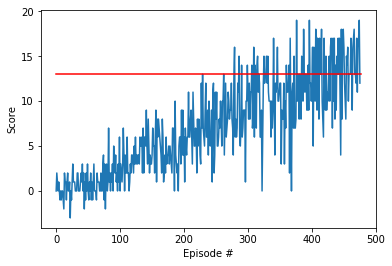

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores,
         label='Agent score')
plt.plot([0, len(scores)], [score_target, score_target],
         color='red', label='Target score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Tipically, the previous plot is quite noisy due to the stochastic nature of the learning process.

# 3. Agent in action

The plot looks nice, but did our agent learn to collect the bananas?

Let's see it in action.

In [5]:
hidden_units = 64
num_layers = 2
snapshot_file = './checkpoint.pth'

# query environment for info
env_info = env.reset(train_mode=False)[env.brain_names[0]]
action_size = env.brains[env.brain_names[0]].vector_action_space_size
state_size = len(env_info.vector_observations[0])

# setup agent
agent = Agent(state_size=state_size, action_size=action_size,
              seed=0, hidden_units=hidden_units,
              num_layers=num_layers)
agent.qnetwork_local.load_state_dict(torch.load(snapshot_file))

state = env_info.vector_observations[0]
score = 0
while True:
    action = agent.act(state)
    env_info = env.step(action)[env.brain_names[0]]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state
    if done:
        break
print('The agent achieves:', score)
env.close()

# 4. Departing words

It was great to see how a simple algorithm such as DQN managed to solved this particular navigation challenge. There are definitely more steps towards the holy-grail of autonomous navigation. For example,

1. More efificient learning.

  DQN is great. However, there are a couple of enhacements that could be improved:
  -  Prioritized experience replay. Currently, the past experiences used to train our brain is by sampling uniform random. However, we could argue that some experiences may be more "important" than others. Moreover, it is possible that such "important" experiences are infrequent and our agents ends up sampling them less often. Therefore, it would be ideal to implement a mechanism to sampling experiences in a non-uniform way based on some criterion.
  
  - Dueling DQN. The current implentation only predicts the "Q-Value" function $Q(s, a)$ which is determined by the state and action pair. However, we could decompose such function in terms of a "State value function" $V(s)$ and an "Advantage value function" $A(s, a)$ such that $Q(s, a) = V(s) + Q(s, a)$. This decomposition has the nice properties of associating a value to the states which inherently promotes a smoother approximation.

2. State representation.

  Currently, our agent relies on a state representation of `37` diminensions of the environment which seems pretty advance and a bit unnatural. To push forward the limits of autonomous navigation, it is also important to study how to learn such compact representation simply from the raw visual information provided by the simulator.